In [1]:
from keras.datasets import mnist
import matplotlib.pyplot as plt
import cv2
import numpy as np
from keras.layers import Input,Lambda,Dense, Flatten, Dropout, Conv2D, AveragePooling2D, MaxPool2D
from keras.models import Model, Sequential
from keras.callbacks import ModelCheckpoint
from keras.preprocessing.image import load_img, ImageDataGenerator
from keras.preprocessing.image import img_to_array
from tensorflow.keras.utils import to_categorical
import tensorflow as tf

In [2]:
img_height, img_width = 450,450

In [3]:
def img_reader():
    img_name = input('Please enter the filename of the puzzle you want to read: ')
    img = cv2.imread(img_name, cv2.IMREAD_GRAYSCALE)
    img = cv2.resize(img,(img_width,img_height))
    return img

In [259]:
# Read our example
img = img_reader()

Please enter the filename of the puzzle you want to read: Sudoku2.png


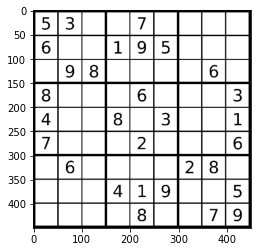

In [260]:
# Show our image
plt.imshow(img,cmap='gray')

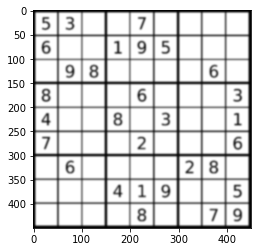

In [261]:
# Apply some pre-processing
# Gaussian Blur, Thresholding, Dilation
proc = cv2.GaussianBlur(img.copy(), (9, 9), 0)
plt.imshow(proc,cmap='gray')


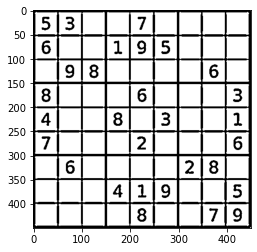

In [262]:
# Thresholding
process = cv2.adaptiveThreshold(proc, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 11, 2)
plt.imshow(process,cmap='gray')

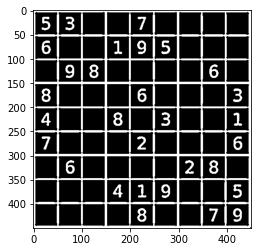

In [263]:
# Color-inversion
process = cv2.bitwise_not(process, process)
plt.imshow(process,cmap='gray')

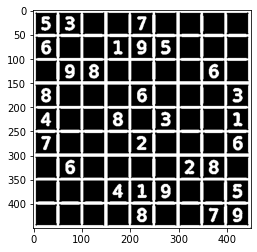

In [264]:
# Dilation
kernel = np.array([[0., 1., 0.], [1., 1., 1.], [0., 1., 0.]], np.uint8)
process = cv2.dilate(process, kernel)
plt.imshow(process,cmap='gray')

In [265]:
# Combine into 1 function
def preprocessing(img):
    proc = cv2.GaussianBlur(img.copy(), (9, 9), 0)
    proc = cv2.adaptiveThreshold(proc, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 11, 2)
    proc= cv2.bitwise_not(proc, proc)
    return proc

In [266]:
img_processed = preprocessing(img)

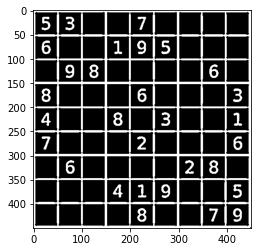

In [267]:
plt.imshow(img_processed,cmap='gray')

In [268]:
img_contours = img.copy()
big_conts = img.copy()
contours, hierarcy = cv2.findContours(img_processed,cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)
#cv2.drawContours(img_contours, contours, -1, (0,255,0),3)

In [269]:
# Get the biggest contour
def biggestContour(contours):
    biggest = np.array([])
    max_area = 0
    for i in contours:
        area = cv2.contourArea(i)
        if area > 50:
            peri = cv2.arcLength(i,True)
            approx = cv2.approxPolyDP(i,0.02*peri,True)
            if area > max_area and len(approx) == 4:
                biggest = approx
                max_area
    return biggest, max_area

In [270]:
corners = biggestContour(contours)[0]

In [271]:
# Standardize the order of points
def order_points(points):
    points = points.reshape((4,2))
    points_n = np.zeros((4,1,2),dtype=np.int32)
    add = points.sum(1)
    points_n[0] = points[np.argmin(add)]
    points_n[3] = points[np.argmax(add)]
    diff = np.diff(points,axis=1)
    points_n[1] = points[np.argmin(diff)]
    points_n[2] = points[np.argmax(diff)]
    return points_n

In [272]:
# Extract corners and order them
corners = order_points(corners)
print(corners)

[[[  2   0]]

 [[449   2]]

 [[  0 447]]

 [[447 449]]]


In [273]:
point1 = np.float32(corners)
point2 = np.float32([[0,0],[img_width,0],[0,img_height],[img_width,img_height]])
matrix = cv2.getPerspectiveTransform(point1,point2)
img_warp_col = cv2.warpPerspective(img_processed,matrix,(img_width,img_height))
#img_warp_col = cv2.cvtColor(img_warp_col,cv2.COLOR_BGR2GRAY)

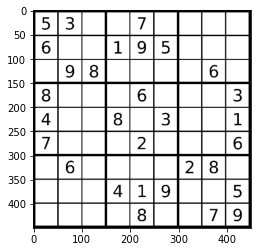

In [274]:
# Check if we found the correct contour
plt.imshow(cv2.drawContours(big_conts,corners,-1,(0,255,0),10),cmap='gray')
# Seems good

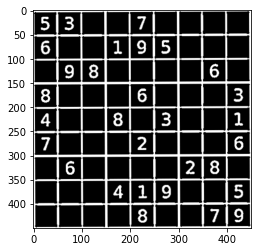

In [275]:
plt.imshow(img_warp_col,cmap='gray')

In [276]:
# Now, we want to split the image into a 9 x 9 
# totalling 81 separate images that we 
# will feed into a MNIST-trained CNN that we have created
# based on LeNet-5 architecture

In [277]:
# This means we need to reshape our data because our CNN accepts 28 x 28 inputs.
# We will also crop our image by quite a bit since to avoid the presence of the white lines
def splitter(img_arr):
    rows = np.vsplit(img_arr,9)
    boxes = []
    for r in rows:
        cols = np.hsplit(r,9)
        for c in cols:
            cropped = c[1:-1,1:-1]
            crp_resized = cv2.resize(cropped,(28,28))
            boxes.append(crp_resized)
    return np.array(boxes)

In [278]:
split_imgs = splitter(img_warp_col)
print(np.shape(split_imgs))

(81, 28, 28)


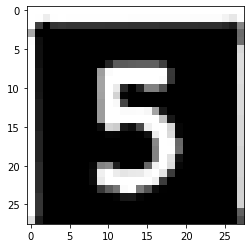

In [279]:
# Check the output
# Looks good
plt.imshow(split_imgs[0],cmap='gray')

In [280]:
# First we load the model
# Since the model file only contains weights,
# We still need to define the CNN's architecture 
# loading the weights

In [281]:
# Model definition
tf.compat.v1.reset_default_graph()

model = Sequential()
model.add(Conv2D(filters=32, kernel_size=(5,5), padding='same', activation='relu', input_shape=(28, 28, 1)))
model.add(MaxPool2D(strides=2))
model.add(Conv2D(filters=48, kernel_size=(5,5), padding='valid', activation='relu'))
model.add(MaxPool2D(strides=2))
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dense(84, activation='relu'))
model.add(Dense(10, activation='softmax'))

In [282]:
# loading the model with the least val acc
from keras.models import load_model

model = load_model('weights-improvement-07-0.99.hdf5')

In [283]:
# Now we reshape our data into the proper format so
# we can feed it as a prediction input into our model

X_shaped = split_imgs.reshape(split_imgs.shape[0],28,28,1)

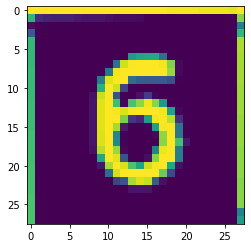

In [284]:
plt.imshow(X_shaped[31])

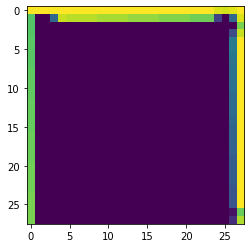

In [285]:
plt.imshow(X_shaped[15])

In [286]:
predictions = model.predict(X_shaped)

In [287]:
classes = np.argmax(predictions,axis=1)

In [288]:
classes

array([5, 3, 0, 0, 7, 0, 0, 0, 0, 6, 0, 0, 1, 9, 5, 0, 0, 0, 0, 9, 8, 0,
       0, 0, 0, 6, 0, 8, 0, 0, 0, 6, 0, 0, 0, 3, 4, 0, 0, 8, 0, 3, 0, 0,
       1, 7, 0, 0, 0, 2, 0, 0, 0, 6, 0, 6, 0, 0, 0, 0, 2, 8, 0, 0, 0, 0,
       4, 1, 9, 0, 0, 5, 0, 0, 0, 0, 8, 0, 0, 7, 9], dtype=int64)

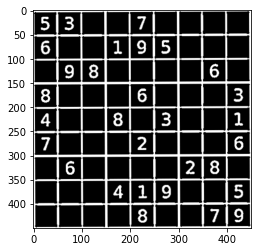

In [289]:
plt.imshow(img_warp_col,cmap='gray')

In [290]:
with open('sudoku_puzzle.txt','w') as f:
    i = 0
    for c in classes:
        if i in [8,17,26,35,44,53,62,71,80]:
            f.write(str(c)+'\n')
        else:
            f.write(str(c)+',')
        i+=1
    f.close()